#### **Parts:**
1. Theoretical and simulated spectra: TT, EE, BB, TE
2. Simulate point sources 
    1. Maps for T, Q, U, P
    2. Maps for E, B
3. Add white noise
4. Labels

In [1]:
import pandas as pd
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import wget

In [2]:
# Map parameters
nside = 1024
fwhm_arcmin = 7.4 # Simons Observatory for 27GHz: https://arxiv.org/pdf/1808.07445.pdf
fwhm = fwhm_arcmin * np.pi/(180*60) #rad
l_pix = hp.nside2resol(nside, arcmin=False) # must be in radians
npix = hp.nside2npix(nside)

In [3]:
%store npix

Stored 'npix' (int)


In [4]:
%store nside
%store fwhm
%store l_pix

Stored 'nside' (int)
Stored 'fwhm' (float)
Stored 'l_pix' (float64)


#### **1. Theoretical and simulated spectra: TT, EE, BB, TE**

In [5]:
# We download the theoretical power spectrum Planck 
url = 'https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/cosmoparams/COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt'
filename = 'Power_spectrum.txt'

if not os.path.exists(filename):
    wget.download(url, filename)
else:
    print("File already exists")

File already exists


In [6]:
# We read the data
data = pd.read_fwf(filename, index_col=None, infer_nrows=2508)
data = data.drop(columns=['#'])

In [7]:
%store data

Stored 'data' (DataFrame)


The power spectrum for the theoretical and simulated CMB is inside TT_27GHz.ipynb, EE_27GHz.ipynb, BB_27GHz.ipynb and TE_27GHz.ipynb

#### **2. Simulate point sources**

The visualisation of the power spectrum for the point sources is inside TT.ipynb, EE.ipynb, BB.ipynb and TE.ipynb

##### **For the map CMB + Point Sources + Noise, we simulate all the possible fluxes. On the other hand, for the map Labels, we only simulate fluxes above 500mJy. This cut-off is done in the section *6. Labels***

Inside the file Flux_Density_Distribution.ipynb in Number_Counts/Src

In [8]:
%store -r S_new
%store -r number_ps
%store -r nu

### Adjustment of units: from Jy to K

 $\left.\Delta I_{\mathrm{cmb}}(\hat{\boldsymbol{x}}, \nu) \approx \frac{\partial B(\nu, T)}{\partial T}\right|_{T=T_0} \Delta T_{\mathrm{cmb}}(\hat{\boldsymbol{x}})$ 
 
 $\left.\frac{\partial B(\nu, T)}{\partial T}\right|_{T=T_0} \approx 24.8\left[\frac{x^2}{\sinh (x / 2)}\right]^2 \mathrm{Jy} \mathrm{ sr}^{-1}(\mu \mathrm{K})^{-1}$

Source: Hobson et al. 1998 (https://arxiv.org/pdf/astro-ph/9806387.pdf)

Therefore, $I_{\mathrm{cmb}} = 24.8\left[\frac{x^2}{\sinh (x / 2)}\right]^2  \cdot T_{\mathrm{cmb}} \hspace{0.4cm} \mathrm{Jy} \hspace{0.1cm} \mathrm{ sr}^{-1}$

$$
\begin{align}
\boxed{T_{\mathrm{cmb}} \hspace{0.1cm}(\mathrm{K}) = \frac{1}{24.8}\left[\frac{\sinh (x / 2)}{x^2}\right]^2  \cdot I_{\mathrm{cmb}}[\mathrm{Jy \hspace{0.1cm} sr^{-1}}] \cdot 10^{-6}}
\end{align}
\hspace{0.3cm}\mathrm{with} \hspace{0.3cm} x \approx \nu/56.8 \hspace{0.1cm} \mathrm{GHz}
$$

In [9]:
# Convert Jy to Kelvin
def jy_to_kelvin(nu, flux_jy, l_pix): #l_pix in rad
    x = nu/56.8
    prefactor = 1/24.8 * 10**(-6) * (np.sinh(x/2)/x**2)**2
    T = prefactor * flux_jy
    T = T/l_pix**2
    return T
T = jy_to_kelvin(nu, S_new, l_pix)

#### **A) Maps for T, Q, U, P**

In [10]:
Pi = 0.02 # polarization degree
P = Pi * T  # polarization intensity
np.random.seed(0)
phi = np.random.random(len(T)) * np.pi # random number [0,π)

# Stokes' parameters
Q = P * np.cos(2 * phi)
U = P * np.sin(2 * phi)
# rho is taken as 1, but the map is finally smoothed to achieve the radial profile behaviour

##### ***Attention:** {T, Q, U, P} are variables that are not smoothed, but {ps_map_T, ps_map_Q, ps_map_U, ps_map_P} are smoothed. Also, {T, Q, U, P} are the quantities for the point sources, not the whole map*

In [11]:
# Generate random positions for the point sources
indices = np.random.choice(npix, size=number_ps, replace=False)

In [12]:
# T Map: it is useful to store the unsmoothed map for later in Section 6
ps_map_T_unsmoothed = np.zeros(npix)

# Add point sources to the map
ps_map_T_unsmoothed[indices] = T

In [13]:
# Q map
ps_map_Q = np.zeros(npix)

# Add point sources to the map
ps_map_Q[indices] = Q

In [14]:
# U map
ps_map_U = np.zeros(npix)

# Add point sources to the map
ps_map_U[indices] = U

In [15]:
ps_map_T, ps_map_Q, ps_map_U = hp.smoothing([ps_map_T_unsmoothed, ps_map_Q, ps_map_U], fwhm, pol = True)

In [16]:
%store ps_map_T
%store ps_map_Q
%store ps_map_U

Stored 'ps_map_T' (ndarray)
Stored 'ps_map_Q' (ndarray)
Stored 'ps_map_U' (ndarray)


In [17]:
# Obtain cl for the point sources map
TT_cl, EE_cl, BB_cl, TE_cl, EB_cl, TB_cl = hp.anafast([ps_map_T,ps_map_Q,ps_map_U], pol=True, alm = False)

In [18]:
%store TT_cl
%store EE_cl
%store BB_cl
%store TE_cl

Stored 'TT_cl' (ndarray)
Stored 'EE_cl' (ndarray)
Stored 'BB_cl' (ndarray)
Stored 'TE_cl' (ndarray)


##### **P map**

In [19]:
# P map
ps_map_P = np.zeros(npix)

# Add point sources to the map
ps_map_P = np.sqrt(ps_map_Q**2+ps_map_U**2) # already smoothed


In [20]:
%store ps_map_P

Stored 'ps_map_P' (ndarray)


#### **B) Maps for E and B**

Inside the file EB_maps_27GHz.ipynb

In [21]:
%store -r E
%store -r B

#### **3. Add white noise**

Inside the file White_noise_27GHz.ipynb

The visualisation of the power spectrum for the point sources is inside TT.ipynb, EE.ipynb, BB.ipynb and TE.ipynb

#### **4. Labels**

Tests done previously in the folder Test_patches_labels.ipynb

##### **Cut-off**

Given that there are many sources and most of them have very low fluxes (which will be hidden by the cmb), they end up forming almost a continuum of emission as if it were a background or extra noise. In reality, it is impossible to separate specific sources from this background, so what we do to avoid asking for the impossible and confusing the network is to distinguish between detectable and non-detectable sources. The idea is to include all the sources generated in the cmb + sources + noise maps passed to the network as a training (and validation) signal, but only label a fraction of them.

In [22]:
# Define the flux threshold and convert to Kelvin
S_threshold = 500e-03 # In Jy
T_threshold = jy_to_kelvin(nu, S_threshold, l_pix)

# Find the indices of the point sources where the flux is above the threshold
indices_threshold = np.where(ps_map_T_unsmoothed > T_threshold)[0]

# Select the values of the flux S_new above the threshold and convert to Kelvin
S_new_threshold = S_new[S_new > S_threshold]
T_new_threshold = jy_to_kelvin(nu, S_new_threshold, l_pix)

In [24]:
# We set the maximum and minimum flux [Jy]. As a comparison, np.max(S_new)= 9.6 and np.min(S_new)=1e-3
P_min = S_threshold 
P_max = 1

In [25]:
# We convert to Kelvin
T_min = jy_to_kelvin(nu, P_min, l_pix)
T_max = jy_to_kelvin(nu, P_max, l_pix)

In [26]:
r_min = 3.5 * np.pi/180/60  # rad
r_max = 13 * np.pi/180/60  # rad

In [27]:
# Calculate radii
m = (r_max - r_min) / (T_max - T_min)
r = r_min + m * (T_new_threshold - T_min)
r[r < r_min] = 0
r[r > r_max] = r_max 

In [28]:
map_labels = np.zeros(npix)
# Fill the map with the point sources and their radii
for i, pos in enumerate(indices_threshold):
    vec = hp.pix2vec(nside, pos)
    r_i = r[i]
    idx = hp.query_disc(nside, vec, r_i)
    map_labels[idx] = 1
    

In [29]:
%store map_labels

Stored 'map_labels' (ndarray)


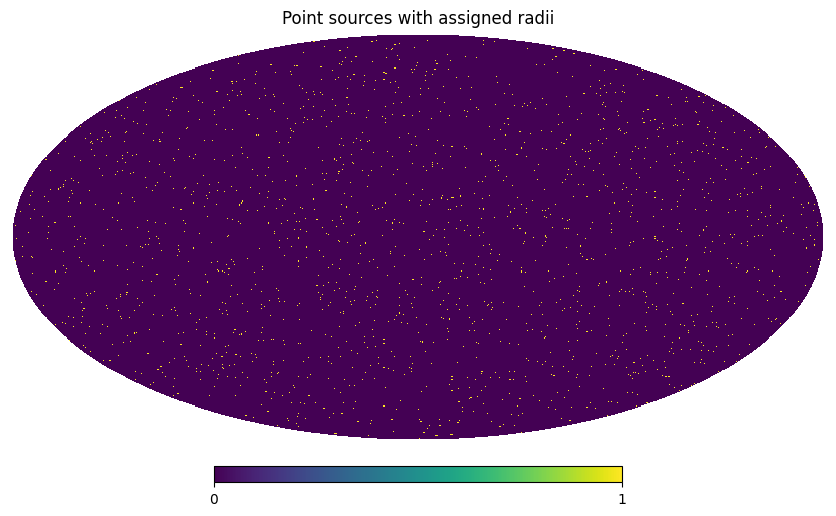

In [30]:
# Show the map
hp.mollview(map_labels, title='Point sources with assigned radii')
plt.savefig('Sky_map_labels.png', dpi=300)

In the file Zoomed_in_patches.ipynb you can find the zoomed maps for ps_map_T, ps_map_Q, ps_map_U and map_labels

In [31]:
%store indices
%store T
%store Q
%store U
%store phi

Stored 'indices' (ndarray)
Stored 'T' (ndarray)
Stored 'Q' (ndarray)
Stored 'U' (ndarray)
Stored 'phi' (ndarray)


In [32]:
%store indices_threshold

Stored 'indices_threshold' (ndarray)


In [33]:
%store T_new_threshold

Stored 'T_new_threshold' (ndarray)


#### **Other**

##### **Some possible useful commands**

```
# We can convert rad to pix
def rad2pix(size_arcmin):
    res = np.sqrt(4*np.pi/(12*nside**2))
    pixel_size = size_rad / res
    return pixel_size
```